In [1]:
from itertools import combinations, groupby

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial


from pymutspec.draw import plot_mutspec192, plot_mutspec12

### Read file with counted codons

In [2]:
counted_codons = pd.read_csv("../data/counted_codons_cytb.csv")
counted_codons = counted_codons.drop("Gene", axis=1)
# counted_codons  = counted_codons.drop("Unnamed: 0", axis=1)
counted_codons.head()


,Species,ExpectedObserved,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,...,A[G>C]A,A[G>T]A,A[G>T]G,A[G>T]T,A[T>A]A,A[T>A]G,A[T>A]T,A[T>G]A,A[T>G]G,A[T>G]T
0,Abbottina_obtusirostris,Expected,8.0,4.0,4.0,4.0,12.0,10.0,10.0,17.0,...,0,0,0,0,0,0,0,0,0,0
1,Abbottina_obtusirostris,Observed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Abbottina_rivularis,Expected,6.0,3.0,3.0,3.0,16.0,11.0,9.0,21.0,...,0,0,0,0,0,0,0,0,0,0
3,Abbottina_rivularis,Observed,2.0,1.0,0.0,1.0,6.0,4.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,Abramis_brama,Expected,9.0,3.0,4.0,5.0,8.0,9.0,9.0,18.0,...,0,0,0,0,0,0,0,0,0,0


###  Change format of table for better counting

In [3]:
_counted_codons = counted_codons.melt(["Species", "ExpectedObserved"], counted_codons.columns[2:], var_name="Mut")
_counted_codons.head()

,Species,ExpectedObserved,Mut,value
0,Abbottina_obtusirostris,Expected,A[A>G]A,8.0
1,Abbottina_obtusirostris,Observed,A[A>G]A,0.0
2,Abbottina_rivularis,Expected,A[A>G]A,6.0
3,Abbottina_rivularis,Observed,A[A>G]A,2.0
4,Abramis_brama,Expected,A[A>G]A,9.0


In [4]:
mutations = _counted_codons.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
mutations.head()

ExpectedObserved,Species,Mut,Expected,Observed
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0


### Calculate RawMuspec for each species

In [5]:
mutations["RawMutSpec"] = (mutations["Observed"] / mutations["Expected"]).fillna(0)
mutations["RawMutSpec"] = mutations["RawMutSpec"].replace(np.inf, 0)
mutations.head()

ExpectedObserved,Species,Mut,Expected,Observed,RawMutSpec
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0


In [6]:
rawsum_df = mutations.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
rawsum_df.head()

,Species,RawMutSpecSum
0,Abbottina_obtusirostris,1.088889
1,Abbottina_rivularis,67.375092
2,Abramis_brama,8.375200
3,Acanthogobius_hasta,3.213889
4,Acanthopagrus_latus,0.154762


### Final Mutational spectrum

In [17]:
mutspecs = pd.merge(mutations, rawsum_df, on="Species")
mutspecs["MutSpec"] = mutspecs["RawMutSpec"] / mutspecs["RawMutSpecSum"]
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0


In [8]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

### Here we translate our mutspec with reverse on HEAVY CHAIN

In [18]:
mutspecs['Mut'] = mutspecs.Mut.apply(getrevers)
mutspecs["MutBase"] = mutspecs.Mut.str.slice(2, 5)
mutspecs["Context"] = mutspecs.Mut.str.get(0) + mutspecs.Mut.str.get(2) + mutspecs.Mut.str.get(-1)
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT


### Function to draw MutSpec

### Plot Mutational Spectrum for all Vertebrates

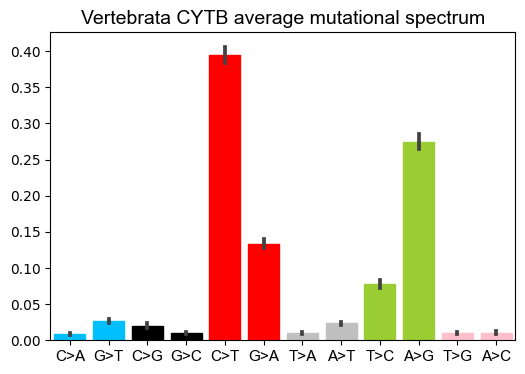

In [19]:
_species_spectra12 = mutspecs.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata CYTB average mutational spectrum",
    savepath="../pictures/MutSpec/Mut12Vert.pdf")

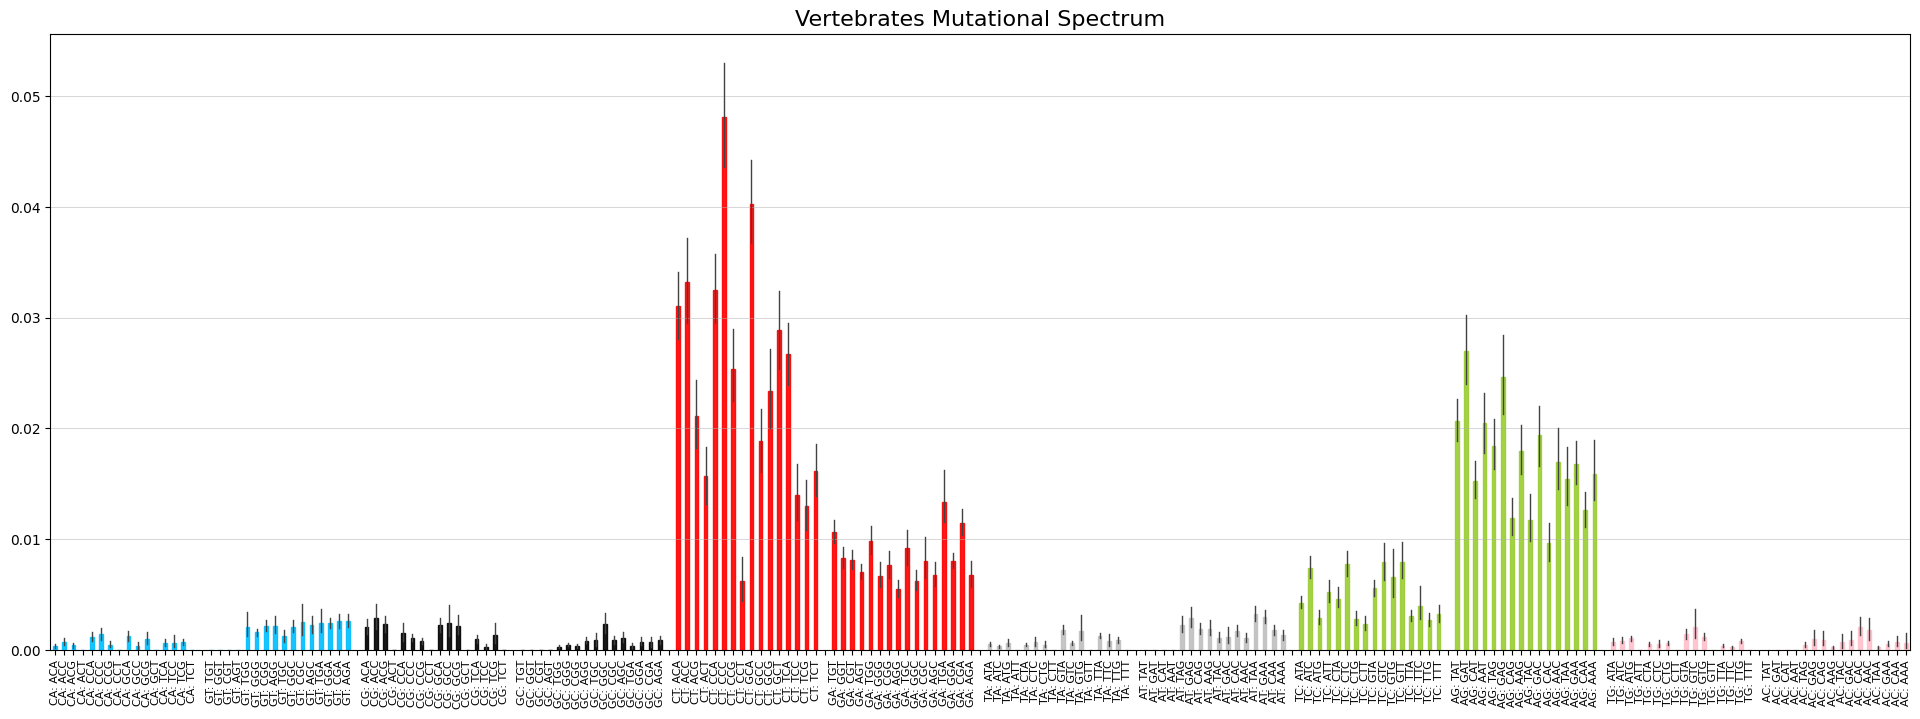

In [22]:
plot_mutspec192(mutspecs, title='Vertebrates Mutational Spectrum', savepath='../pictures/MutSpec/MutSpec192Vert.pdf',
                fontname='Courier', ticksize=8, labels_style='long')

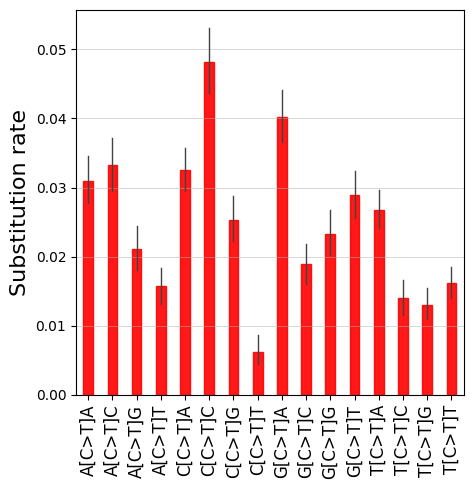

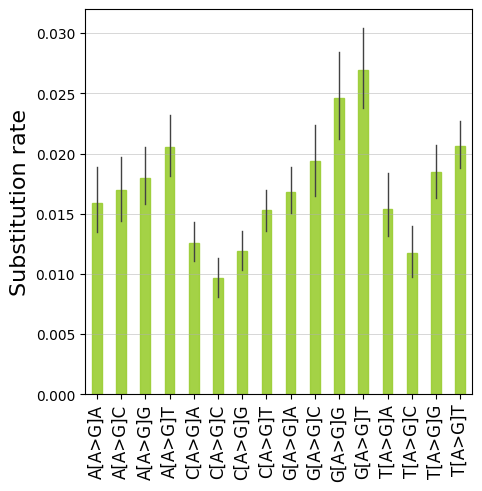

In [24]:
from pymutspec.draw.sbs_orders import ordered_sbs192_kp


plot_mutspec192(mutspecs, title="", ylabel="Substitution rate",  fontname="Courier", 
                ticksize=12, sbs_order=ordered_sbs192_kp[64:64+16], figsize=(5, 5), savepath="../pictures/fig5a.pdf") # svg
plot_mutspec192(mutspecs, title="", ylabel="Substitution rate", fontname="Courier", 
                ticksize=12, sbs_order=sorted(ordered_sbs192_kp[16*9:16*9+16]), figsize=(5, 5), savepath="../pictures/fig5b.pdf") # svg

### Add taxonomy and get mutspec for 5 orders

In [11]:
taxa = pd.read_csv('../data/taxa_gb.csv', sep='\t')
taxa.head()

,Class,Species
0,Aves,Corvus_frugilegus
1,Mammalia,Rhinopithecus_bieti
2,Mammalia,Cheracebus_lugens
3,Mammalia,Chiropotes_israelita
4,Mammalia,Callimico_goeldii


### How many classes we have

How many classes obtained from mutspec

In [12]:
taxa['Class'].value_counts()

Actinopterygii    2855
Mammalia          1464
Aves              1007
Amphibia           325
Lepidosauria       294
Name: Class, dtype: int64

How many species by classes left after merging with mutspec

In [13]:
final_mutspec = pd.merge(mutspecs, taxa, on='Species')
final_mutspec = final_mutspec.drop_duplicates()

In [14]:
final_mutspec['Class'].value_counts()//192

Actinopterygii    457
Mammalia          384
Aves               72
Lepidosauria       36
Amphibia           25
Name: Class, dtype: int64

How many species we have

In [15]:
len(final_mutspec.Species.unique())

974

In [44]:
# save mutspec of cytb for all vertebrates
final_mutspec.to_csv('../data/MutSpecVertebratescytb.csv', index=False)

### Make SuplFile1, where one row - one species

In [16]:
final_mutspec.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [28]:
suplfile1 = final_mutspec.drop(['Expected', 'Observed', 'RawMutSpec', 'RawMutSpecSum', 'MutBase', 'Context'], axis=1)
suplfile1.head()

,Species,Mut,MutSpec,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,0.0,Actinopterygii


In [29]:
suplfile1 = suplfile1.pivot(index=["Species"], columns="Mut", values="MutSpec").reset_index()
suplfile1 = pd.merge(suplfile1, taxa, on='Species')
suplfile1 = suplfile1.drop_duplicates()
suplfile1.head()

,Species,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[A>T]A,...,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,Class
0,Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.000000,0.0,0.153061,0.000000,0.0,...,0.0,0.051020,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,Actinopterygii
1,Abbottina_rivularis,0.0,0.0,0.0,0.0,0.002474,0.0,0.000000,0.000000,0.0,...,0.0,0.005937,0.0,0.004947,0.004947,0.002474,0.0,0.0,0.0,Actinopterygii
2,Abramis_brama,0.0,0.0,0.0,0.0,0.000000,0.0,0.014925,0.026533,0.0,...,0.0,0.027554,0.0,0.010855,0.000000,0.000000,0.0,0.0,0.0,Actinopterygii
3,Acanthogobius_hasta,0.0,0.0,0.0,0.0,0.000000,0.0,0.038894,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,Actinopterygii
4,Acanthopagrus_latus,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,Actinopterygii


In [43]:
# Change order of the columns
cols = suplfile1.columns.to_list()
col_move = 'Class'
cols.remove(col_move)
cols.insert(1,col_move)

suplfile1 = suplfile1[cols]
suplfile1.head()

,Species,Class,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,Abbottina_obtusirostris,Actinopterygii,0.0,0.0,0.0,0.0,0.000000,0.0,0.153061,0.000000,...,0.0,0.0,0.051020,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,Abbottina_rivularis,Actinopterygii,0.0,0.0,0.0,0.0,0.002474,0.0,0.000000,0.000000,...,0.0,0.0,0.005937,0.0,0.004947,0.004947,0.002474,0.0,0.0,0.0
2,Abramis_brama,Actinopterygii,0.0,0.0,0.0,0.0,0.000000,0.0,0.014925,0.026533,...,0.0,0.0,0.027554,0.0,0.010855,0.000000,0.000000,0.0,0.0,0.0
3,Acanthogobius_hasta,Actinopterygii,0.0,0.0,0.0,0.0,0.000000,0.0,0.038894,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,Acanthopagrus_latus,Actinopterygii,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [56]:
suplfile1.to_csv('../ToPaper/SuplFiles/SupplementaryTable1.csv', index=False)


In [57]:
suplfile1.Species.to_csv('../ToPaper/SuplFiles/SupplementaryFile1.csv', index=False) # save only species names for suplfile1

### Draw Mutational Spectra for different classes

In [15]:
taxes_to_draw = ['Mammalia', 'Aves', 'Actinopterygii', 'Lepidosauria', 'Amphibia']

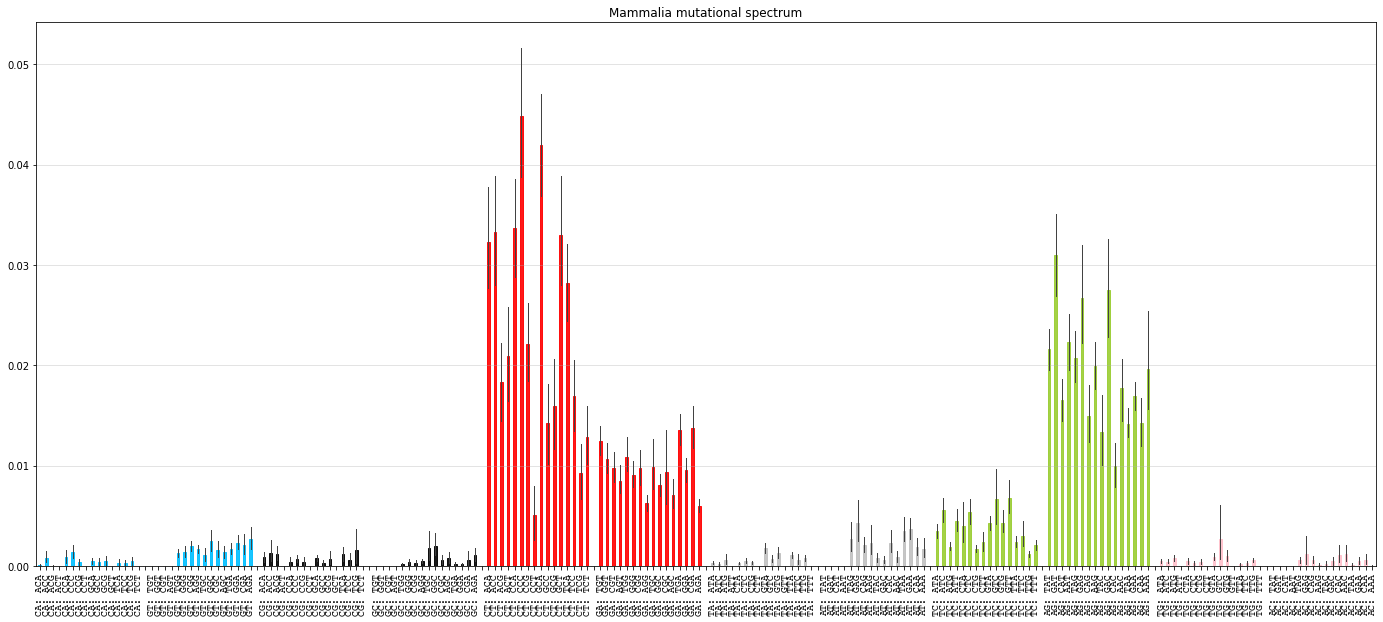

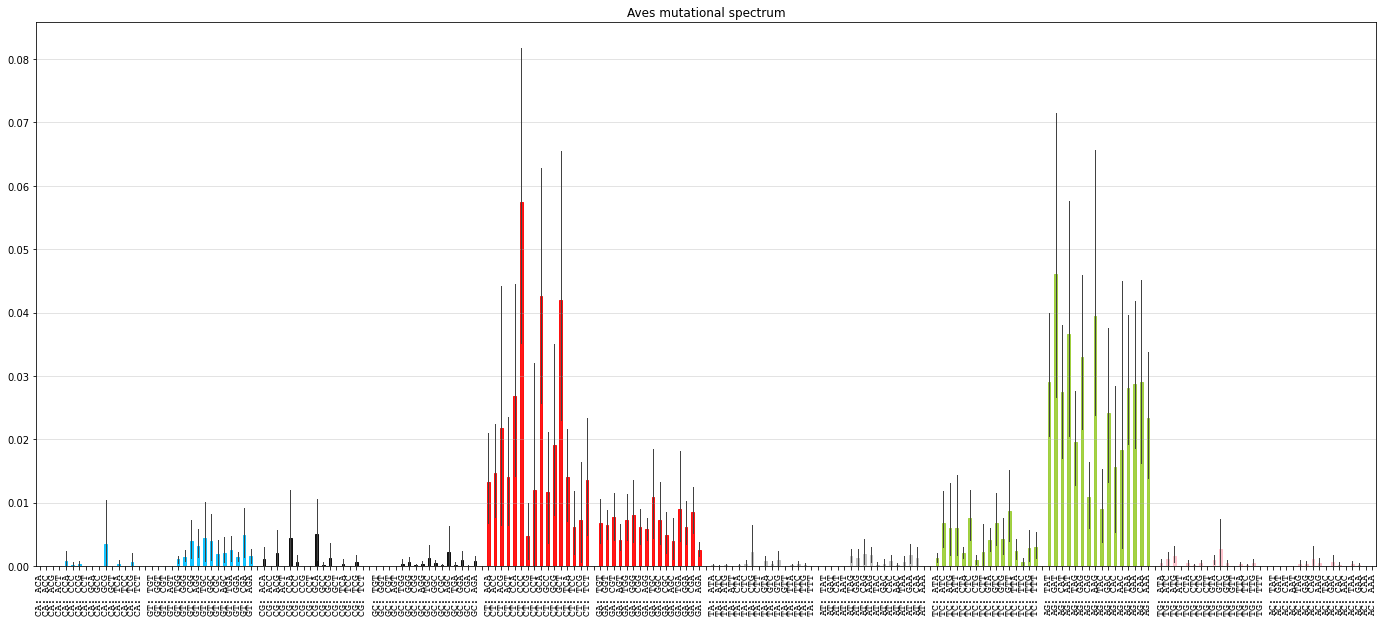

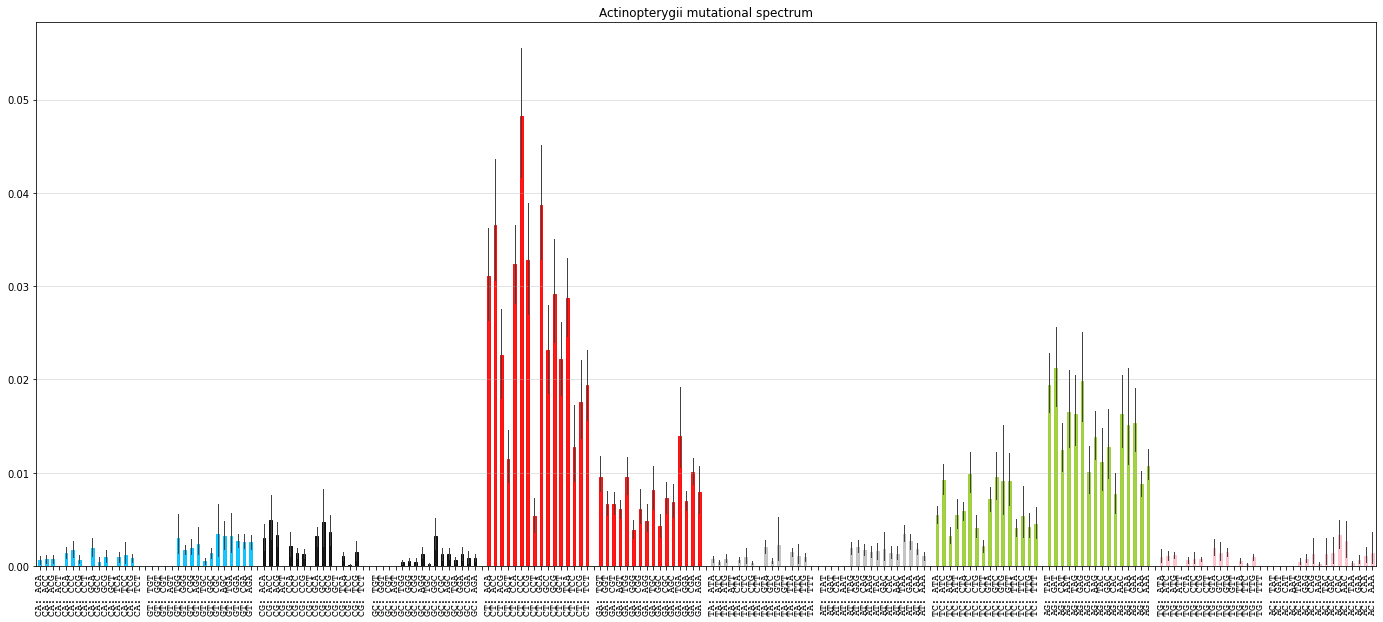

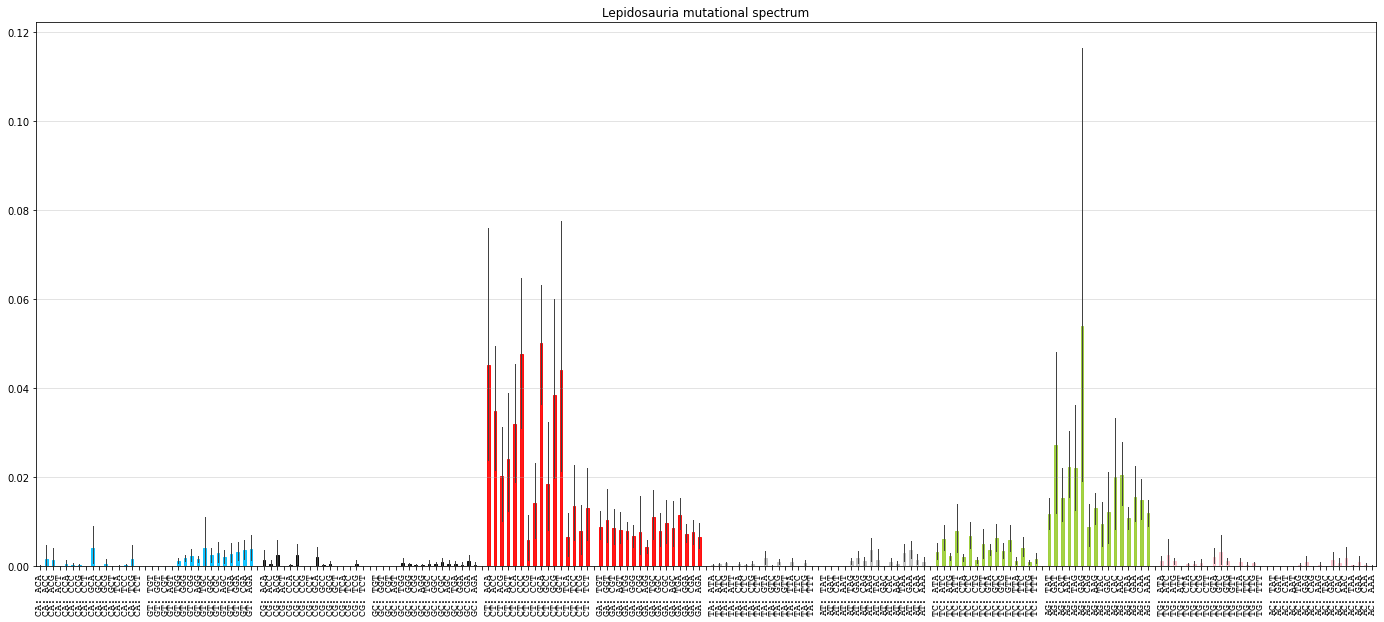

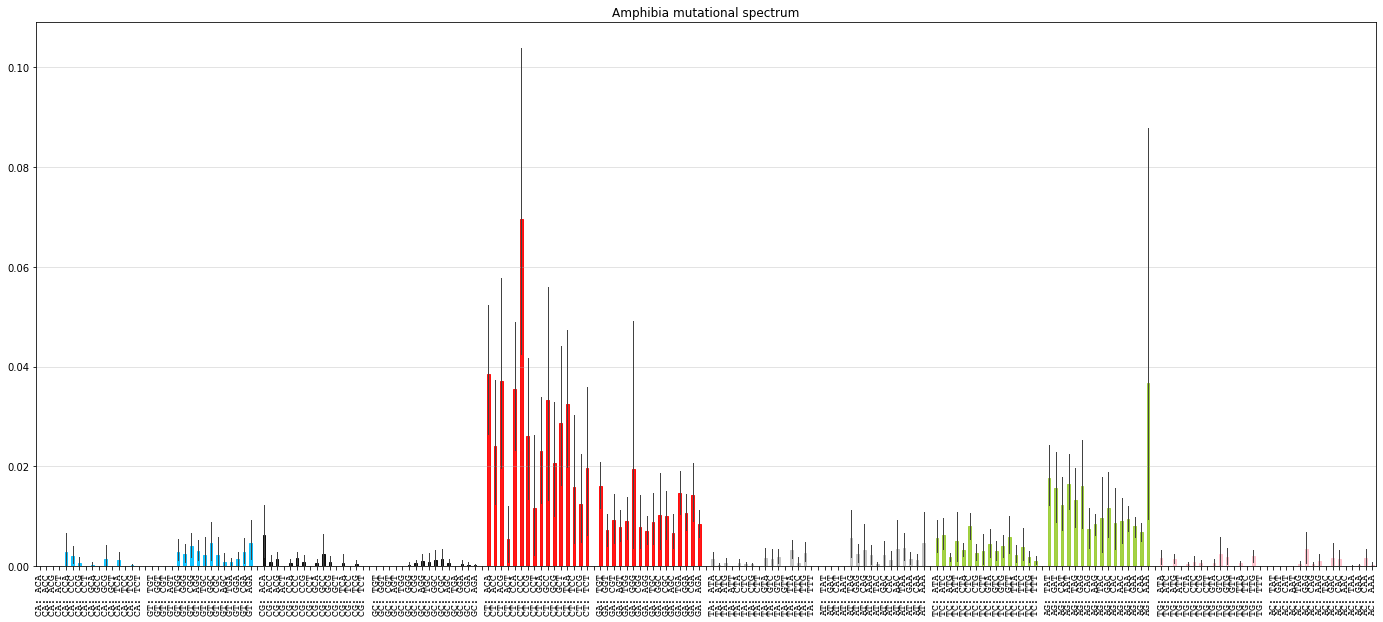

In [50]:
for tax in taxes_to_draw:
    plot_mutspec192(final_mutspec[final_mutspec['Class'] == tax], title=f'{tax} mutational spectrum',
    filepath=f'../pictures/Mutspec/{tax}Mut192Comp.pdf', fontname='Courier', fontsize=10)

In [16]:
needed_classes = ['Mammalia', 'Aves', 'Amphibia', 'Lepidosauria', 'Actinopterygii', 'exdloop']

## Download cancer mutspec 

In [17]:
cancer = pd.read_csv('../data/external/cancer_mutspec.csv')
cancer = cancer.loc[:,['Mut','MutSpec_ExDloop']]

In [18]:
cancer.head()

,Mut,MutSpec_ExDloop
0,A[A>C]A,0.000000
1,A[A>C]C,0.000783
2,A[A>C]G,0.000000
3,A[A>C]T,0.000084
4,A[A>G]A,0.008273


In [19]:
exdloop = cancer.iloc[:,[0,1]]
exdloop['Class'] = 'cancer'
exdloop = exdloop.rename(columns={'MutSpec_ExDloop': 'MutSpec'})


In [21]:
exdloop["MutBase"] = exdloop.Mut.str.slice(2, 5)
exdloop["Context"] = exdloop.Mut.str.get(0) + exdloop.Mut.str.get(2) + exdloop.Mut.str.get(-1)
exdloop.head()

,Mut,MutSpec,Class,MutBase,Context
0,A[A>C]A,0.000000,cancer,A>C,AAA
1,A[A>C]C,0.000783,cancer,A>C,AAC
2,A[A>C]G,0.000000,cancer,A>C,AAG
3,A[A>C]T,0.000084,cancer,A>C,AAT
4,A[A>G]A,0.008273,cancer,A>G,AAA


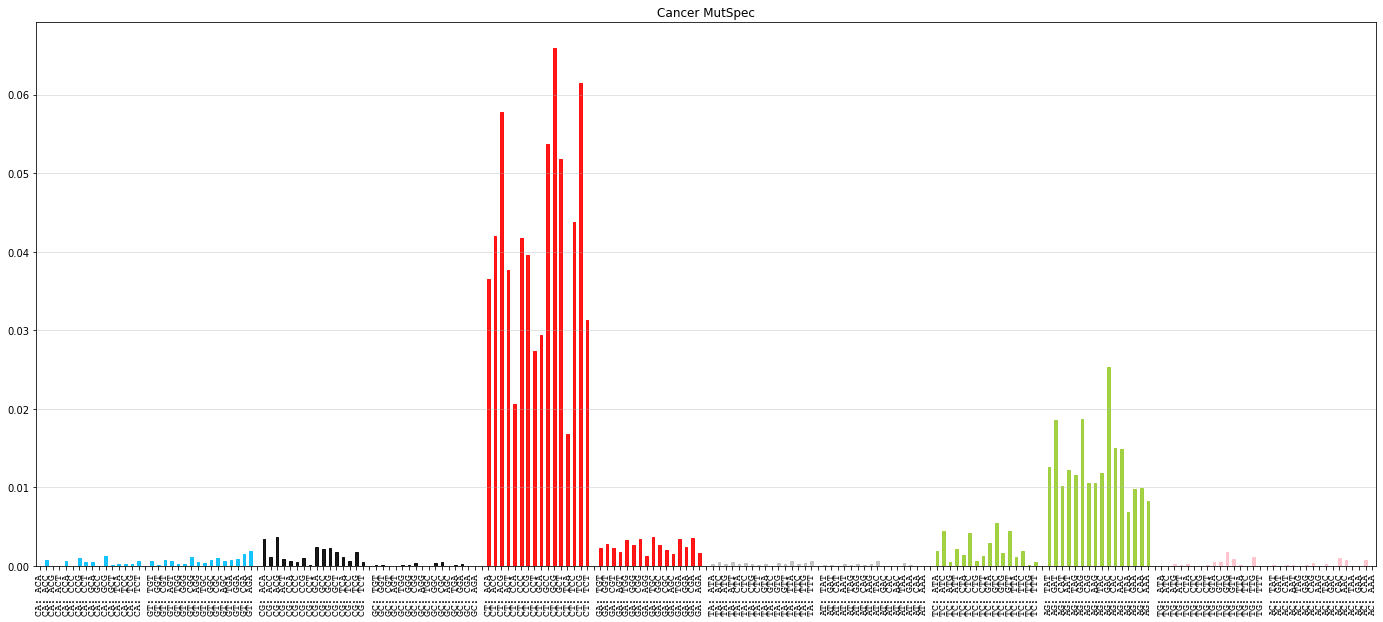

In [23]:
plot_mutspec192(mutspec192=exdloop, title='Cancer MutSpec', filepath='../pictures/MutSpec/MutSpec192Cancers.pdf',
                fontname='Courier', fontsize=10)

### Analysis of C>T on heavy chain as a hallmark of oxidative damage

In [29]:
final_mutspec.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [30]:
CT_only = final_mutspec[final_mutspec['MutBase'] == 'C>T']
C_T_arr = ["A[C>T]A", "A[C>T]C", "A[C>T]G", "A[C>T]T", "C[C>T]A", "C[C>T]C", "C[C>T]G", "C[C>T]T", 
    "G[C>T]A", "G[C>T]C", "G[C>T]G", "G[C>T]T", "T[C>T]A", "T[C>T]C", "T[C>T]G", "T[C>T]T"]

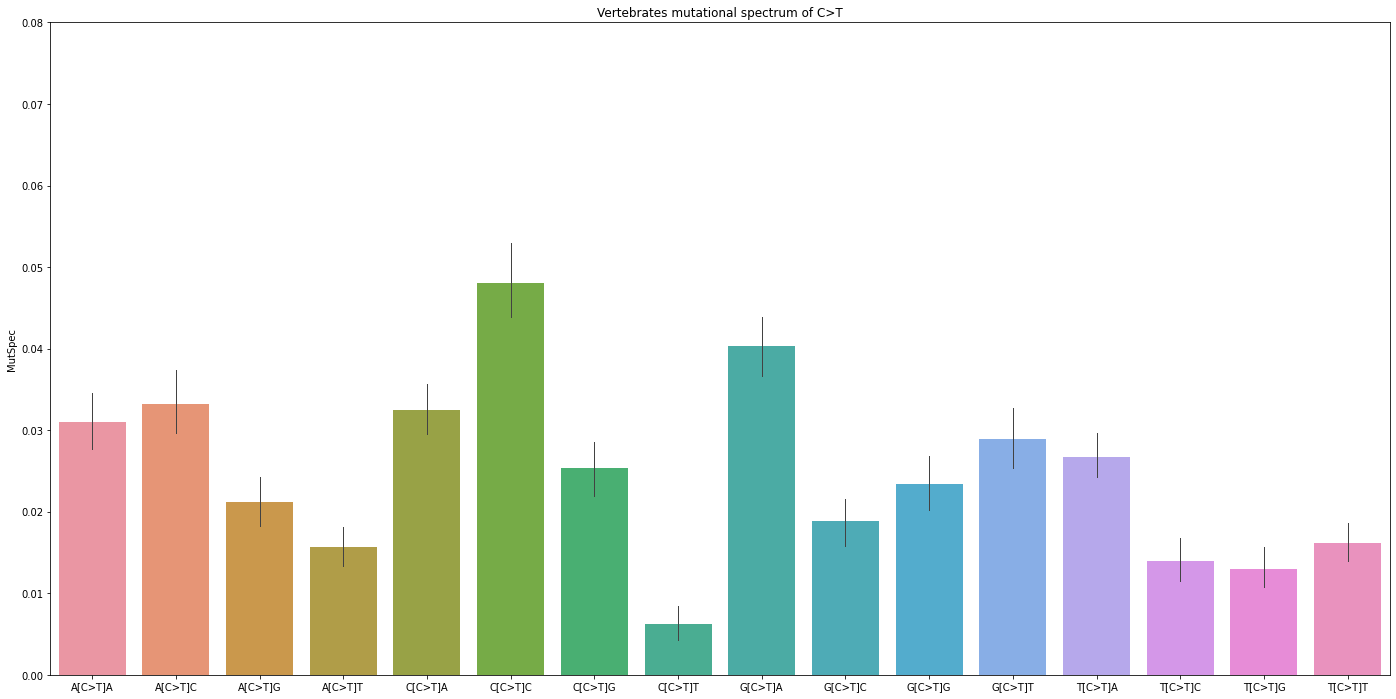

In [31]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=CT_only,
            order=C_T_arr, errwidth=1, ax=fig.gca())
ax.set_xlabel('')
ax.set_title('Vertebrates mutational spectrum of C>T')
ax.set_ylim(0,0.08)
plt.savefig('../pictures/MutSpec/CTMutVert.pdf',dpi=300)


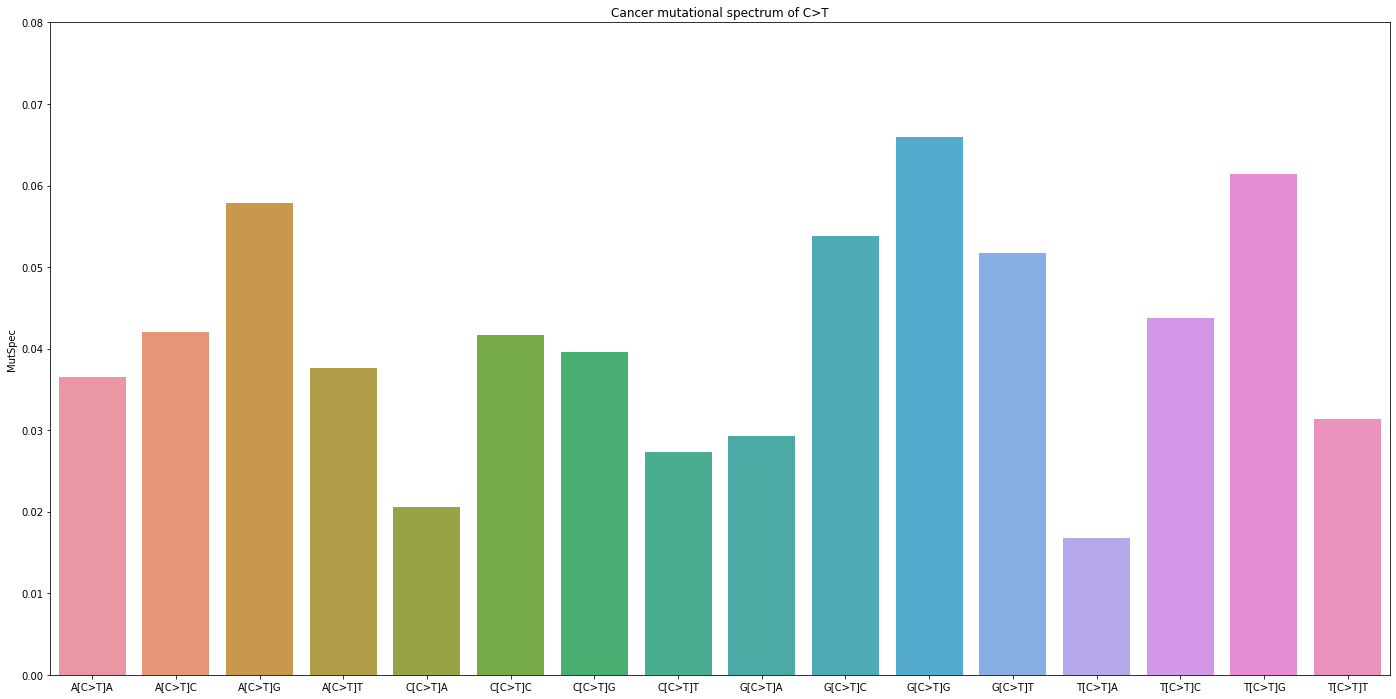

In [32]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=exdloop[exdloop['Mut'].isin(C_T_arr)],
            order=C_T_arr, ax=fig.gca())
ax.set_xlabel('')
ax.set_title('Cancer mutational spectrum of C>T')
ax.set_ylim(0,0.08)
plt.savefig('../pictures/MutSpec/CTMutCancer.pdf',dpi=300)


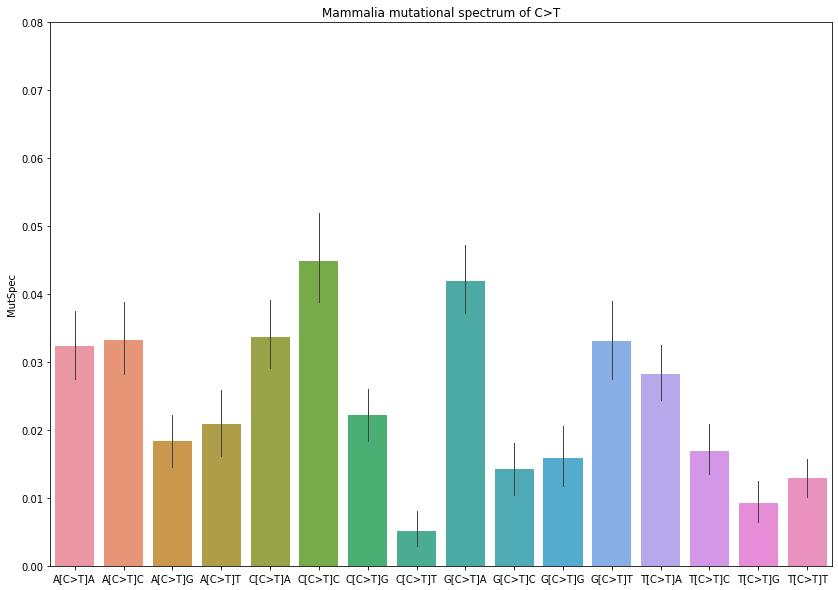

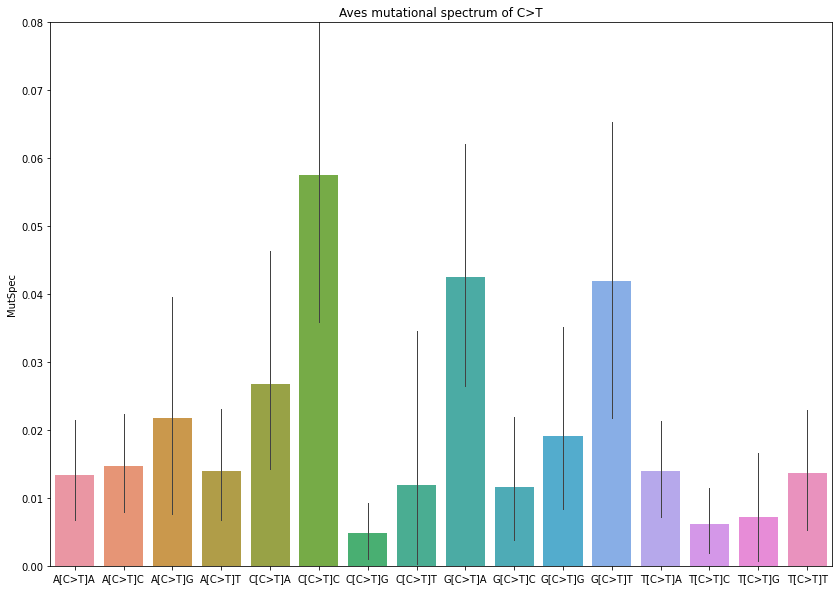

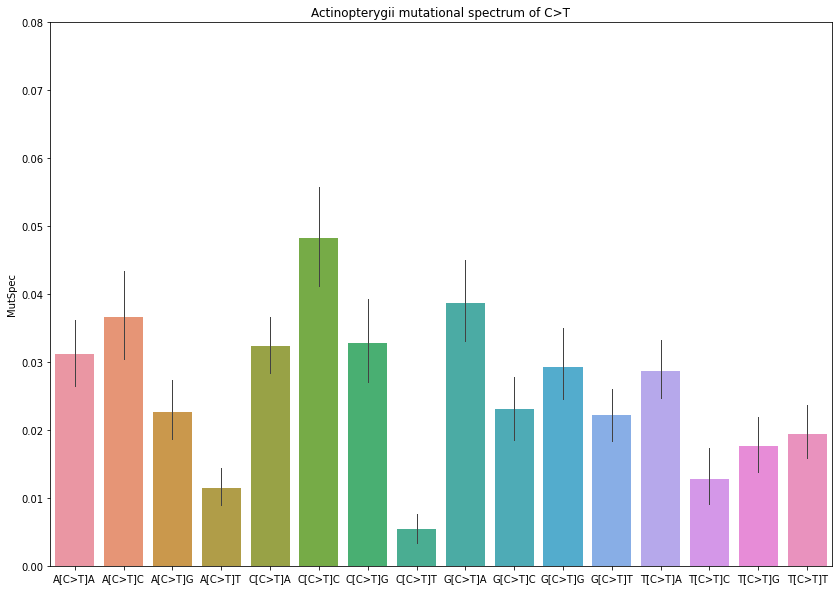

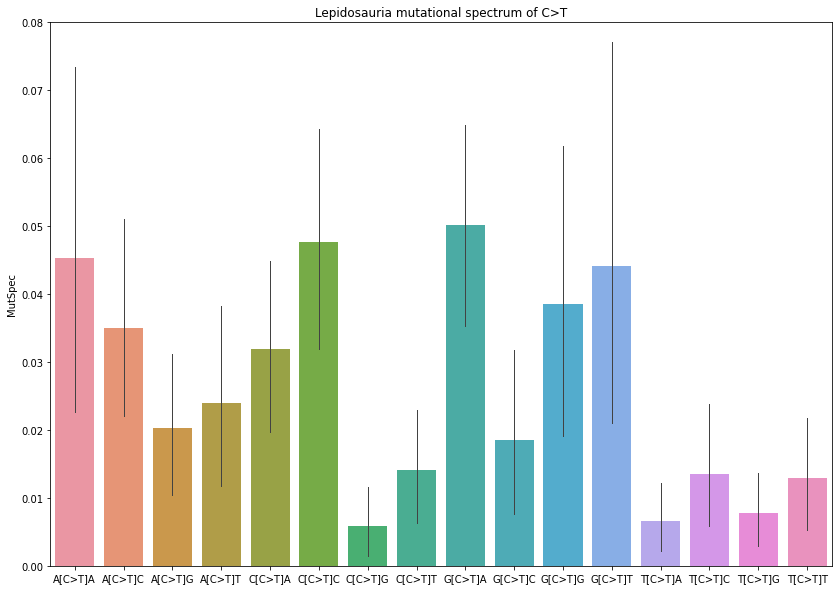

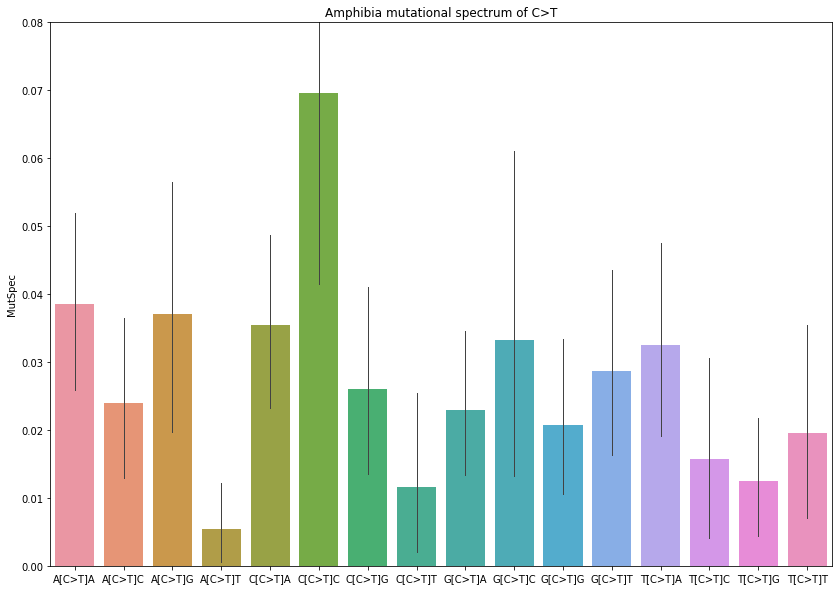

In [41]:
for tx in taxes_to_draw:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)   
    sns.barplot(x="Mut", y="MutSpec", data=CT_only[CT_only.Class == tx],
                order=C_T_arr, errwidth=1, ax=fig.gca())
    ax.set_xlabel('')
    ax.set_title(f'{tx} mutational spectrum of C>T')
    ax.set_ylim(0, 0.08)
    plt.savefig(f'../pictures/MutSpec/CTMut{tx}.pdf',dpi=300)


### Analysis of A>G on heavy chain as a hallmark of 6MA

In [25]:
AG_only = final_mutspec[final_mutspec['MutBase'] == 'A>G']
A_G_arr = ["A[A>G]A", "A[A>G]C", "A[A>G]G", "A[A>G]T", "C[A>G]A", "C[A>G]C", "C[A>G]G", "C[A>G]T", 
    "G[A>G]A", "G[A>G]C", "G[A>G]G", "G[A>G]T", "T[A>G]A", "T[A>G]C", "T[A>G]G", "T[A>G]T"]
colorsAG = ['orange','orange','orange','orange','green','green','green','green',
            'salmon','salmon','salmon','salmon','royalblue','royalblue','royalblue','royalblue']

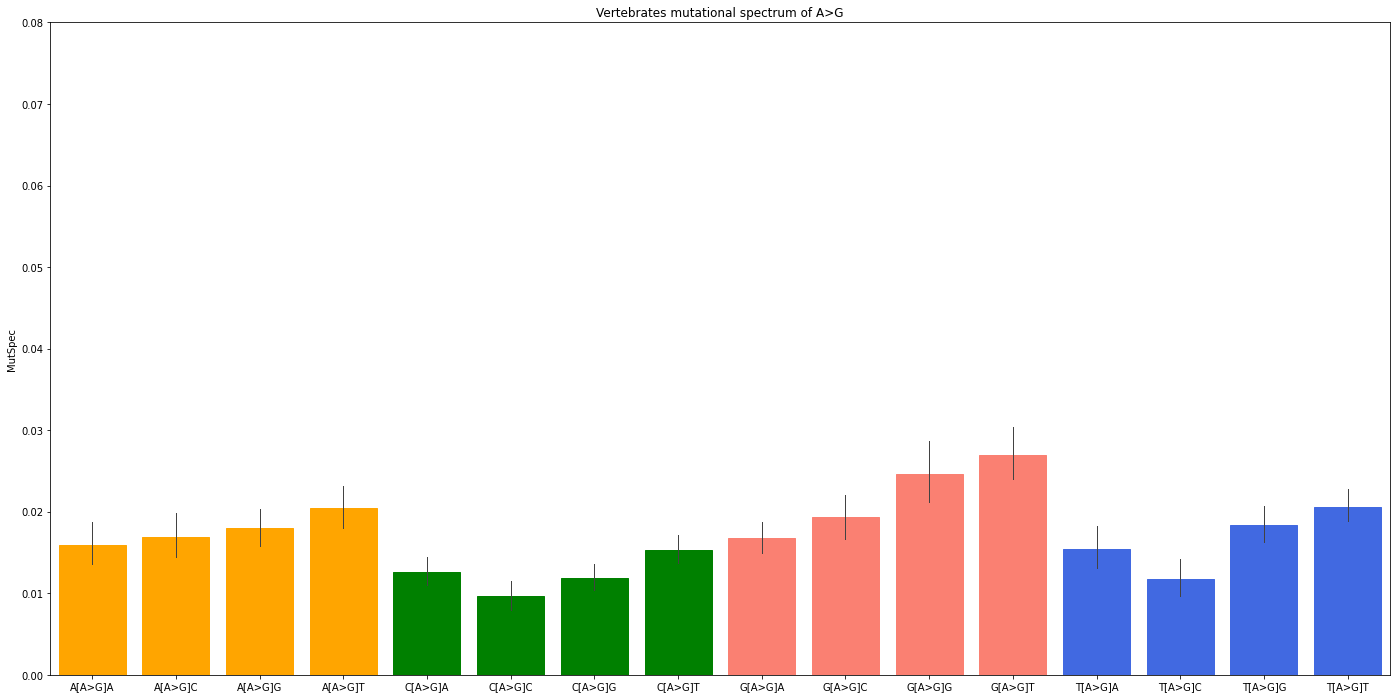

In [35]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=AG_only,
            order=A_G_arr, errwidth=1, ax=fig.gca())
for bar, clr in zip(ax.patches, colorsAG):
        bar.set_color(clr)
ax.set_xlabel('')
ax.set_title('Vertebrates mutational spectrum of A>G')
ax.set_ylim(0, 0.08)
plt.savefig('../pictures/MutSpec/AGMutVert.pdf',dpi=300)
plt.show()

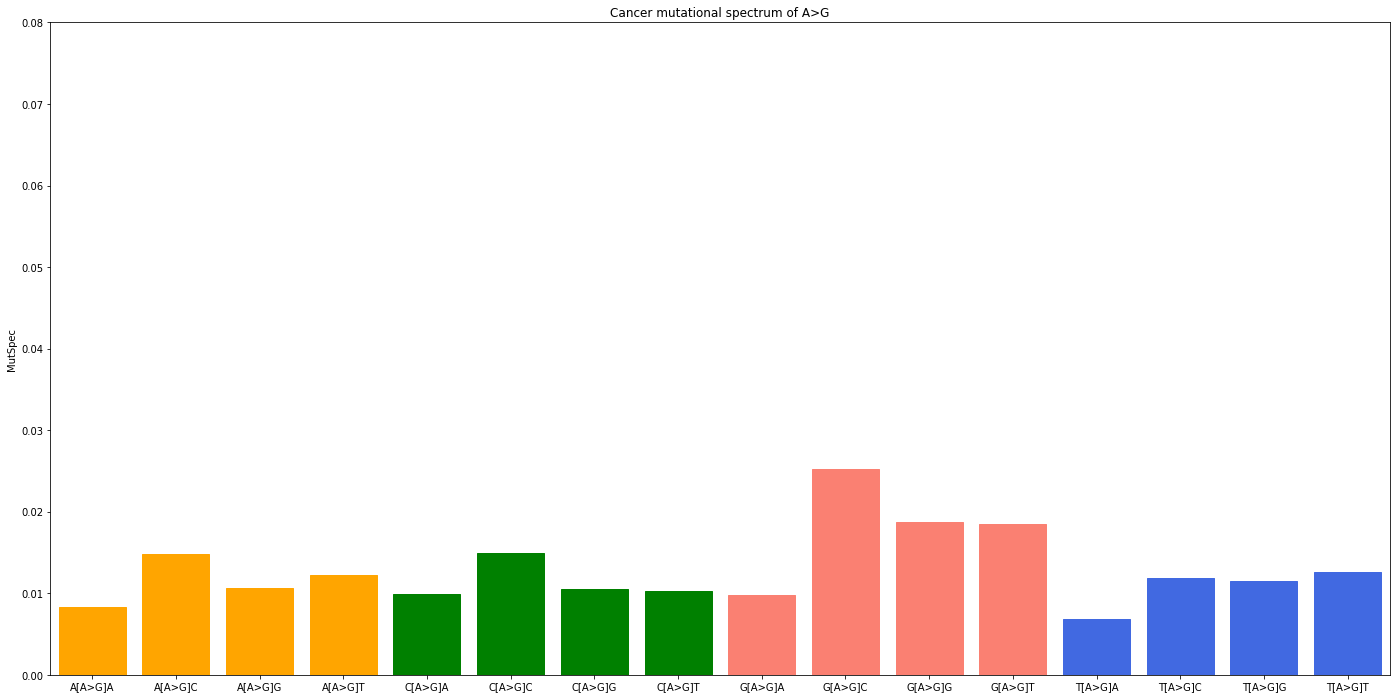

In [36]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=exdloop[exdloop['Mut'].isin(A_G_arr)],
            order=A_G_arr, ax=fig.gca())
for bar, clr in zip(ax.patches, colorsAG):
        bar.set_color(clr)
ax.set_xlabel('')
ax.set_title('Cancer mutational spectrum of A>G')
ax.set_ylim(0,0.08)
plt.savefig('../pictures/MutSpec/AGMutCancer.pdf',dpi=300)


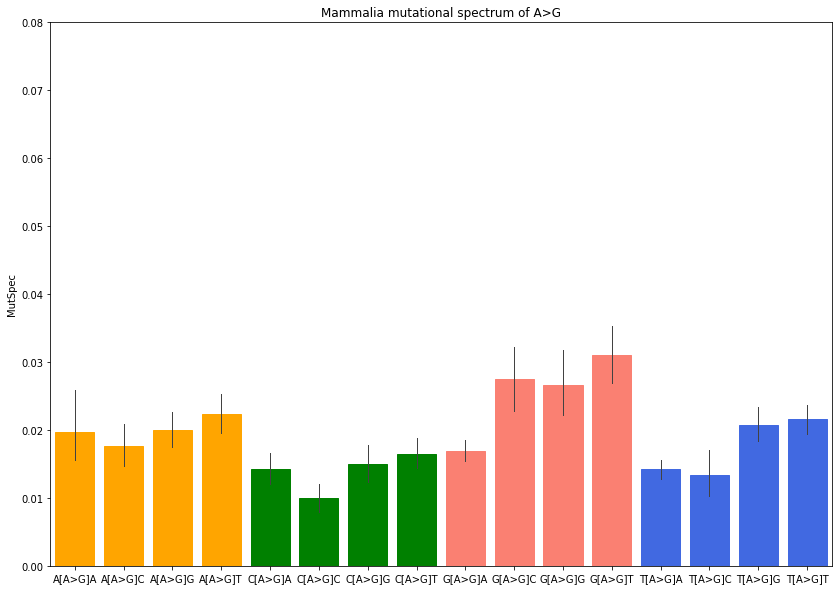

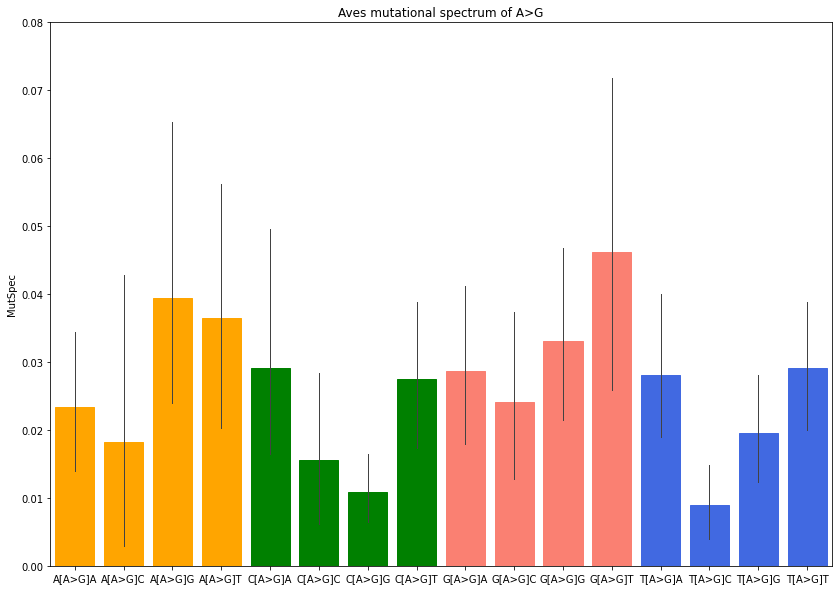

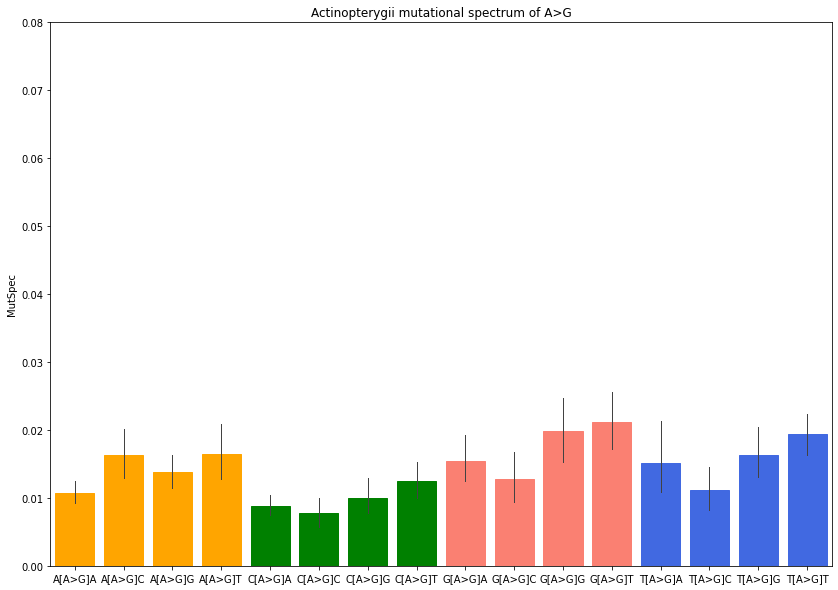

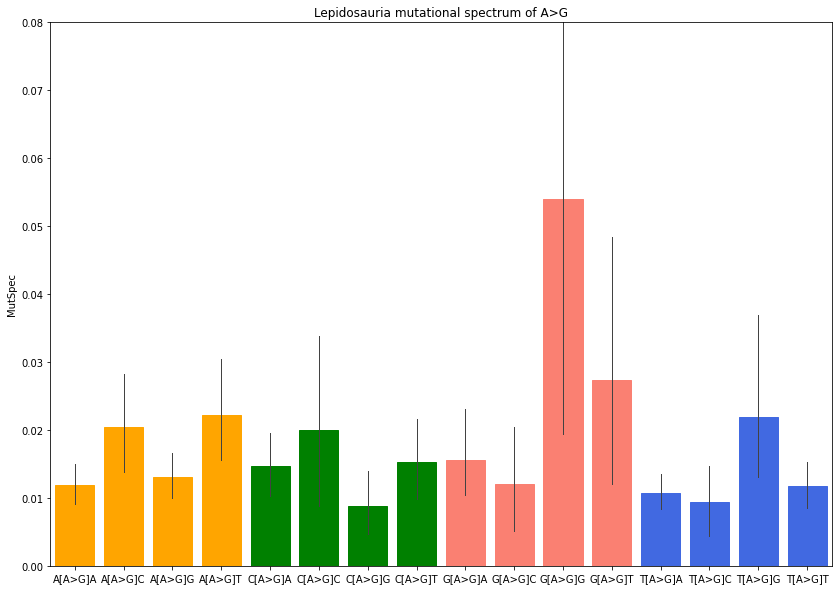

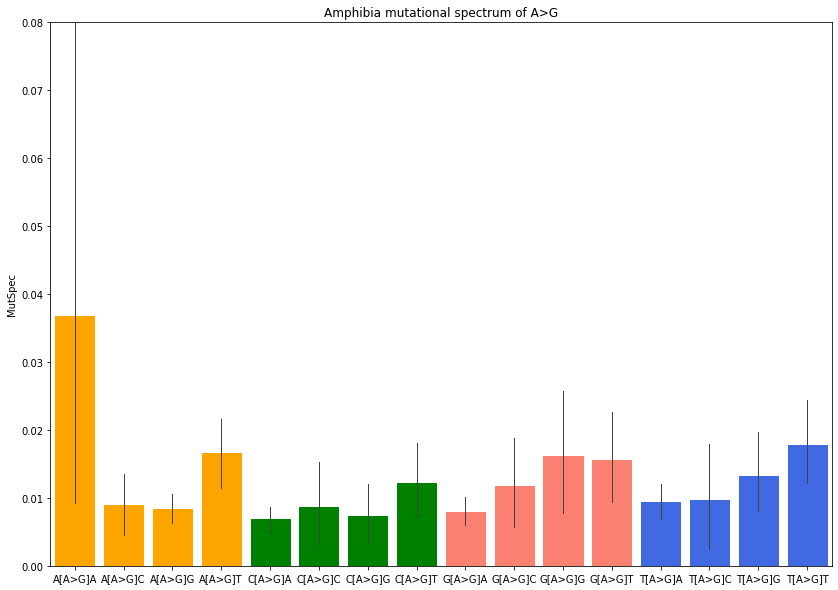

In [40]:
for tx in taxes_to_draw:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)   
    sns.barplot(x="Mut", y="MutSpec", data=AG_only[AG_only.Class == tx],
                order=A_G_arr, errwidth=1, ax=fig.gca())
    for bar, clr in zip(ax.patches, colorsAG):
        bar.set_color(clr)
    ax.set_xlabel('')
    ax.set_title(f'{tx} mutational spectrum of A>G')
    ax.set_ylim(0, 0.08)
    plt.savefig(f'../pictures/MutSpec/AGMut{tx}.pdf',dpi=300)